<a href="https://colab.research.google.com/github/Danieljoshua720/Electricity-demand-forecasting-AIML/blob/main/AIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:


import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Attention
from tensorflow.keras.callbacks import EarlyStopping


In [36]:
df=pd.read_csv('/content/powerdemand_5min_2021_to_2024_with weather.csv')

In [37]:
df.isnull().sum()

,0
Unnamed: 0,0
datetime,0
Power demand,0
temp,0
dwpt,0
rhum,0
wdir,540
wspd,0
pres,0
year,0


In [38]:
df.head()

,Unnamed: 0,datetime,Power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,moving_avg_3
0,0,2021-01-01 00:30:00,2014.00,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,30,NaN
1,1,2021-01-01 00:35:00,2005.63,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,35,NaN
2,2,2021-01-01 00:40:00,1977.60,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,40,1999.076667
3,3,2021-01-01 00:45:00,1976.44,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,45,1986.556667
4,4,2021-01-01 00:50:00,1954.37,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,50,1969.470000


In [39]:
df = df.drop(columns=['Unnamed: 0'])


In [40]:

num_cols = ['wdir', 'pres', 'year', 'month', 'day', 'hour', 'minute', 'moving_avg_3']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())


In [41]:
df.isnull().sum()

,0
datetime,0
Power demand,0
temp,0
dwpt,0
rhum,0
wdir,0
wspd,0
pres,0
year,0
month,0


In [42]:
df['datetime'] = pd.to_datetime(df['datetime'])


In [43]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393440 entries, 0 to 393439
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   datetime      393440 non-null  datetime64[ns]
 1   Power demand  393440 non-null  float64       
 2   temp          393440 non-null  float64       
 3   dwpt          393440 non-null  float64       
 4   rhum          393440 non-null  float64       
 5   wdir          393440 non-null  float64       
 6   wspd          393440 non-null  float64       
 7   pres          393440 non-null  float64       
 8   year          393440 non-null  int32         
 9   month         393440 non-null  int32         
 10  day           393440 non-null  int32         
 11  hour          393440 non-null  int32         
 12  minute        393440 non-null  int32         
 13  moving_avg_3  393440 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int32(5)
memory usage: 34.5 MB


In [45]:
X = df.drop(columns=['datetime', 'Power demand'])
y = df[['Power demand']]


In [46]:
df.tail()

,datetime,Power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,moving_avg_3
393435,2024-12-12 00:10:00,2146.84,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,10,2174.893333
393436,2024-12-12 00:15:00,2116.66,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,15,2139.416667
393437,2024-12-12 00:20:00,2082.77,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,20,2115.423333
393438,2024-12-12 00:25:00,2059.17,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,25,2086.200000
393439,2024-12-12 00:30:00,2049.66,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,30,2063.866667


In [47]:
train_size = int(0.8 * len(df))
val_size   = int(0.1 * len(df))

X_train = X[:train_size]
X_val   = X[train_size:train_size + val_size]
X_test  = X[train_size + val_size:]

y_train = y[:train_size]
y_val   = y[train_size:train_size + val_size]
y_test  = y[train_size + val_size:]

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)


In [49]:
scaler_y = MinMaxScaler(feature_range=(0, 1))

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)


In [50]:
import numpy as np

def create_sequences(X, y, time_steps=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)


In [51]:
time_steps = 24  # you can adjust based on problem

X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_val_lstm, y_val_lstm     = create_sequences(X_val_scaled, y_val_scaled, time_steps)
X_test_lstm, y_test_lstm   = create_sequences(X_test_scaled, y_test_scaled, time_steps)


In [52]:
print(X_train_lstm.shape)
print(y_train_lstm.shape)


(314728, 24, 12)
(314728, 1)


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 50)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,651 (49.42 KB)

 Trainable params: 12,651 (49.42 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Dictionary to store results
results = {}

# -------------------
# 1️⃣ Vanilla LSTM
# -------------------
vanilla_lstm = Sequential([
    LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
vanilla_lstm.compile(optimizer='adam', loss='mse')
vanilla_lstm.fit(X_train_lstm, y_train_lstm,
                  validation_data=(X_val_lstm, y_val_lstm),
                  epochs=10, batch_size=64, verbose=1)
y_pred_vanilla = vanilla_lstm.predict(X_test_lstm)
results['Vanilla'] = y_pred_vanilla

# -------------------
# 2️⃣ Stacked LSTM
# -------------------
stacked_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50),
    Dense(1)
])
stacked_lstm.compile(optimizer='adam', loss='mse')
stacked_lstm.fit(X_train_lstm, y_train_lstm,
                 validation_data=(X_val_lstm, y_val_lstm),
                 epochs=10, batch_size=64, verbose=1)
y_pred_stacked = stacked_lstm.predict(X_test_lstm)
results['Stacked'] = y_pred_stacked

# -------------------
# 3️⃣ LSTM + Dropout
# -------------------
lstm_dropout = Sequential([
    LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)
])
lstm_dropout.compile(optimizer='adam', loss='mse')
lstm_dropout.fit(X_train_lstm, y_train_lstm,
                 validation_data=(X_val_lstm, y_val_lstm),
                 epochs=10, batch_size=64, verbose=1)
y_pred_dropout = lstm_dropout.predict(X_test_lstm)
results['Dropout'] = y_pred_dropout

# -------------------
# 4️⃣ Bidirectional LSTM
# -------------------
bidir_lstm = Sequential([
    Bidirectional(LSTM(50), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
bidir_lstm.compile(optimizer='adam', loss='mse')
bidir_lstm.fit(X_train_lstm, y_train_lstm,
               validation_data=(X_val_lstm, y_val_lstm),
               epochs=10, batch_size=64, verbose=1)
y_pred_bidir = bidir_lstm.predict(X_test_lstm)
results['Bidirectional'] = y_pred_bidir

# -------------------
# 5️⃣ CNN + LSTM
# -------------------
cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50),
    Dense(1)
])
cnn_lstm.compile(optimizer='adam', loss='mse')
cnn_lstm.fit(X_train_lstm, y_train_lstm,
             validation_data=(X_val_lstm, y_val_lstm),
             epochs=10, batch_size=64, verbose=1)
y_pred_cnn = cnn_lstm.predict(X_test_lstm)
results['CNN-LSTM'] = y_pred_cnn


Epoch 1/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 67s 13ms/step - loss: 0.0056 - val_loss: 5.5655e-04
Epoch 2/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 68s 14ms/step - loss: 1.8990e-04 - val_loss: 2.2255e-04
Epoch 3/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - loss: 1.6432e-04 - val_loss: 2.1081e-04
Epoch 4/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 1.4578e-04 - val_loss: 1.7248e-04
Epoch 5/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - loss: 1.2078e-04 - val_loss: 1.6925e-04
Epoch 6/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 1.1858e-04 - val_loss: 1.6768e-04
Epoch 7/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - loss: 1.1011e-04 - val_loss: 1.7881e-04
Epoch 8/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 67s 14ms/step - loss: 1.1894e-04 - val_loss: 1.8501e-04
Epoch 9/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - loss: 1.0777e-04 - val_loss: 1.6586e-04
Epoch 10/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - loss: 1.0847e-04 - val_loss: 1.9205e-04
1229/1229 ━━━━━━━━━━━━━

In [62]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def run_all_15_tests(
    model,
    history,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
):
    results = {}

    # Predictions
    y_train_pred = model.predict(X_train, verbose=0).reshape(-1)
    y_val_pred   = model.predict(X_val, verbose=0).reshape(-1)
    y_test_pred  = model.predict(X_test, verbose=0).reshape(-1)

    y_train = np.array(y_train).reshape(-1)
    y_val   = np.array(y_val).reshape(-1)
    y_test  = np.array(y_test).reshape(-1)

    # Error Metrics
    results["Train_MSE"] = mean_squared_error(y_train, y_train_pred)
    results["Val_MSE"]   = mean_squared_error(y_val, y_val_pred)
    results["Test_MSE"]  = mean_squared_error(y_test, y_test_pred)

    results["Train_RMSE"] = np.sqrt(results["Train_MSE"])
    results["Val_RMSE"]   = np.sqrt(results["Val_MSE"])
    results["Test_RMSE"]  = np.sqrt(results["Test_MSE"])

    results["Train_MAE"] = mean_absolute_error(y_train, y_train_pred)
    results["Val_MAE"]   = mean_absolute_error(y_val, y_val_pred)
    results["Test_MAE"]  = mean_absolute_error(y_test, y_test_pred)

    # Percentage Errors
    eps = 1e-8
    results["MAPE"] = np.mean(np.abs((y_test - y_test_pred) / (y_test + eps))) * 100
    results["sMAPE"] = np.mean(
        2 * np.abs(y_test - y_test_pred) /
        (np.abs(y_test) + np.abs(y_test_pred) + eps)
    ) * 100

    # Generalization
    results["Overfitting_Gap"] = results["Val_MSE"] - results["Train_MSE"]
    results["Robustness_Ratio"] = (
        results["Val_MSE"] / results["Test_MSE"]
        if results["Test_MSE"] != 0 else np.nan
    )

    # Stability (safe)
    if history is not None and "val_loss" in history.history:
        val_losses = history.history["val_loss"]
        results["Stability_Score"] = np.std(val_losses[-3:])
        results["Best_Epoch"] = np.argmin(val_losses) + 1
    else:
        results["Stability_Score"] = np.nan
        results["Best_Epoch"] = np.nan

    # Model size
    results["Total_Params"] = model.count_params()

    return results

In [64]:
models = {
    "Vanilla LSTM": vanilla_lstm,
    "Stacked LSTM": stacked_lstm,
    "Dropout LSTM": lstm_dropout,
    "Bidirectional LSTM": bidir_lstm,
    "CNN-LSTM": cnn_lstm
}

all_results = {}

for name, model in models.items():
    print(f"\n================ {name} =================")

    results = run_all_15_tests(
        model, None,
        X_train_lstm, y_train_lstm,
        X_val_lstm, y_val_lstm,
        X_test_lstm, y_test_lstm
    )

    all_results[name] = results

    for k, v in results.items():
        print(f"{k:20s}: {v}")



================ Vanilla LSTM =================
Train_MSE           : 0.00010690864065148186
Val_MSE             : 0.00016573341081895293
Test_MSE            : 0.00010894858341843798
Train_RMSE          : 0.010339663468966573
Val_RMSE            : 0.012873748903056675
Test_RMSE           : 0.010437843810789563
Train_MAE           : 0.003528652812253708
Val_MAE             : 0.0042174967484785945
Test_MAE            : 0.003989525780327388
MAPE                : 1.017089601762409
sMAPE               : 0.9907287324272886
Overfitting_Gap     : 5.8824770167471076e-05
Robustness_Ratio    : 1.5212075790138722
Stability_Score     : nan
Best_Epoch          : nan
Total_Params        : 12651

================ Stacked LSTM =================
Train_MSE           : 0.00024463684461277523
Val_MSE             : 0.00031922620508669576
Test_MSE            : 0.00032980534901629147
Train_RMSE          : 0.015640870967205605
Val_RMSE            : 0.017866902503979133
Test_RMSE           : 0.0181605437423082

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Collect results in one dictionary
all_results = {
    "Vanilla": vanilla_results,
    "Stacked": stacked_results,
    "Dropout": dropout_results,
    "Bidirectional": bidir_results,
    "CNN-LSTM": cnn_results
}

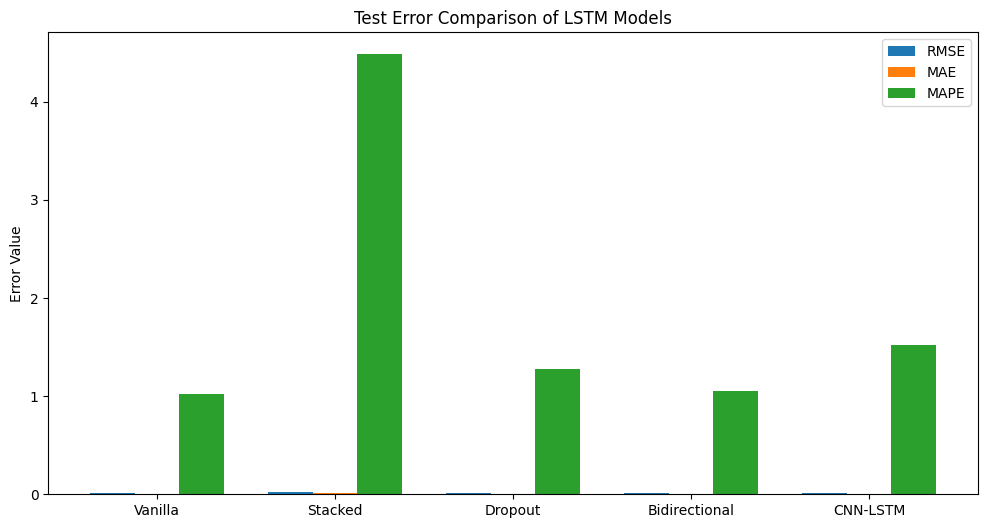

In [66]:
models = list(all_results.keys())
rmse = [all_results[m]['Test_RMSE'] for m in models]
mae  = [all_results[m]['Test_MAE'] for m in models]
mape = [all_results[m]['MAPE'] for m in models]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(12,6))
plt.bar(x - width, rmse, width, label='RMSE')
plt.bar(x, mae, width, label='MAE')
plt.bar(x + width, mape, width, label='MAPE')
plt.xticks(x, models)
plt.ylabel('Error Value')
plt.title('Test Error Comparison of LSTM Models')
plt.legend()
plt.show()

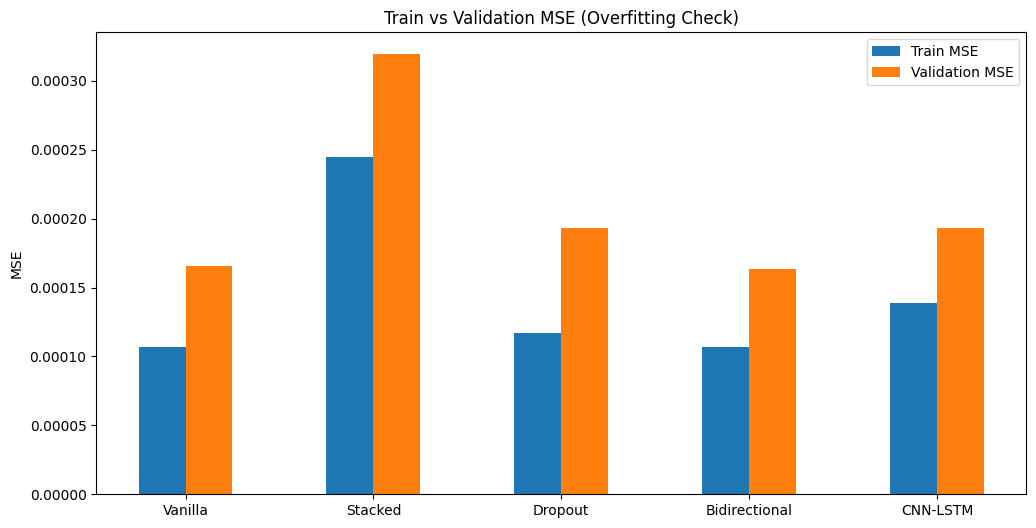

In [67]:
train_mse = [all_results[m]['Train_MSE'] for m in models]
val_mse   = [all_results[m]['Val_MSE'] for m in models]

plt.figure(figsize=(12,6))
plt.bar(x - width/2, train_mse, width, label='Train MSE')
plt.bar(x + width/2, val_mse, width, label='Validation MSE')
plt.xticks(x, models)
plt.ylabel('MSE')
plt.title('Train vs Validation MSE (Overfitting Check)')
plt.legend()
plt.show()


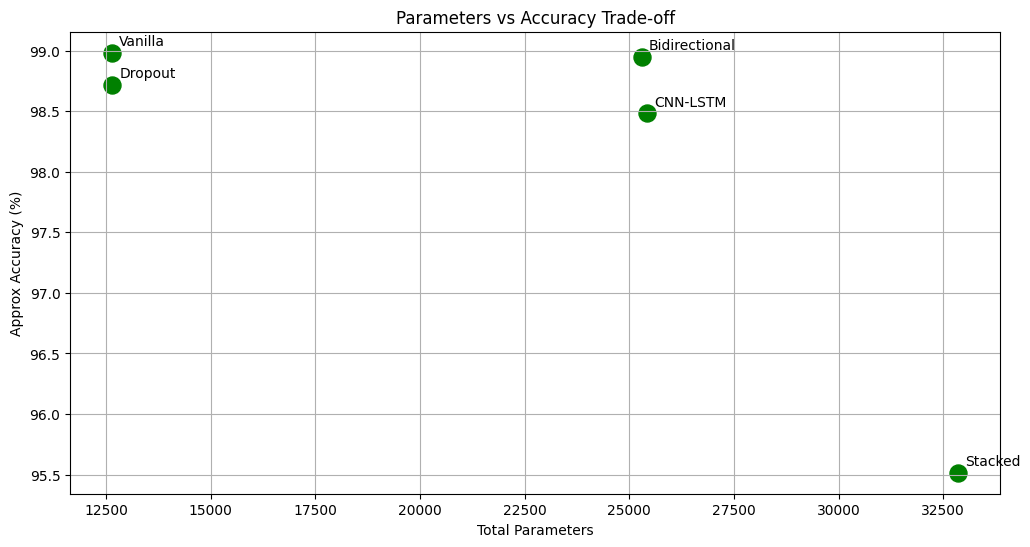

In [68]:
params = [all_results[m]['Total_Params'] for m in models]
accuracy = [100 - all_results[m]['MAPE'] for m in models]  # approx accuracy

plt.figure(figsize=(12,6))
plt.scatter(params, accuracy, s=150, c='green')
for i, txt in enumerate(models):
    plt.annotate(txt, (params[i], accuracy[i]), xytext=(5,5), textcoords='offset points')
plt.xlabel('Total Parameters')
plt.ylabel('Approx Accuracy (%)')
plt.title('Parameters vs Accuracy Trade-off')
plt.grid(True)
plt.show()


In [71]:
from datetime import timedelta

# Get the maximum date in your dataset
max_date = df['datetime'].max()

# Calculate date 1 month before (approx 30 days)
start_date = max_date - timedelta(days=30)

# Filter the last 1 month
df_last_month = df[df['datetime'] >= start_date]

# Check
print(df_last_month)


                  datetime  Power demand  temp  dwpt  rhum   wdir  wspd  \
385154 2024-11-12 00:30:00       2087.72  22.0  19.0  83.0   70.0   3.6   
385155 2024-11-12 00:35:00       2070.68  22.0  19.0  83.0   70.0   3.6   
385156 2024-11-12 00:40:00       2041.88  22.0  19.0  83.0   70.0   3.6   
385157 2024-11-12 00:45:00       2031.12  22.0  19.0  83.0   70.0   3.6   
385158 2024-11-12 00:50:00       2023.29  22.0  19.0  83.0   70.0   3.6   
...                    ...           ...   ...   ...   ...    ...   ...   
393435 2024-12-12 00:10:00       2146.84  12.3   6.8  69.0  269.0   1.8   
393436 2024-12-12 00:15:00       2116.66  12.3   6.8  69.0  269.0   1.8   
393437 2024-12-12 00:20:00       2082.77  12.3   6.8  69.0  269.0   1.8   
393438 2024-12-12 00:25:00       2059.17  12.3   6.8  69.0  269.0   1.8   
393439 2024-12-12 00:30:00       2049.66  12.3   6.8  69.0  269.0   1.8   

          pres  year  month  day  hour  minute  moving_avg_3  
385154  1014.0  2024     11   12    

In [72]:
# Example: features and target
X = df_last_month[['temp','dwpt','rhum','wdir','wspd','pres','moving_avg_3']]  # input features
y = df_last_month['Power demand']  # target


In [73]:
start_date = max_date - pd.DateOffset(months=1)


In [74]:
df_last_month = df_last_month.sort_values('datetime')


In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta


In [76]:
# Assuming your DataFrame is 'df' and 'datetime' is the timestamp column
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# Last 1 month
max_date = df['datetime'].max()
start_date = max_date - timedelta(days=30)  # last 30 days
df_last_month = df[df['datetime'] >= start_date]


In [77]:
# Features
features = ['temp','dwpt','rhum','wdir','wspd','pres','moving_avg_3']
X = df_last_month[features].values

# Target
y = df_last_month['Power demand'].values.reshape(-1, 1)


In [78]:
# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


In [79]:
def create_sequences(X, y, time_steps=12):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 12
X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, time_steps)


In [80]:
train_size = int(0.8 * len(X_lstm))
X_train, X_test = X_lstm[:train_size], X_lstm[train_size:]
y_train, y_test = y_lstm[:train_size], y_lstm[train_size:]


In [85]:
vanilla_lstm = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
vanilla_lstm.compile(optimizer='adam', loss='mse')

# Stacked LSTM
stacked_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(30),
    Dense(1)
])
stacked_lstm.compile(optimizer='adam', loss='mse')

# Dropout LSTM
lstm_dropout = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])
lstm_dropout.compile(optimizer='adam', loss='mse')

# Bidirectional LSTM
bidir_lstm = Sequential([
    Bidirectional(LSTM(50), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
bidir_lstm.compile(optimizer='adam', loss='mse')

# CNN-LSTM
cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50),
    Dense(1)
])
cnn_lstm.compile(optimizer='adam', loss='mse')

# ===========================
# 6️⃣ TRAIN MODELS
# ===========================
models = {
    "Vanilla LSTM": vanilla_lstm,
    "Stacked LSTM": stacked_lstm,
    "Dropout LSTM": lstm_dropout,
    "Bidirectional LSTM": bidir_lstm,
    "CNN-LSTM": cnn_lstm
}

histories = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=50,
        batch_size=32,
        verbose=1
    )
    histories[name] = history



Training Vanilla LSTM ...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0105 - val_loss: 0.0026
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4642e-04 - val_loss: 0.0020
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9468e-04 - val_loss: 0.0026
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8698e-04 - val_loss: 0.0017
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.7231e-04 - val_loss: 0.0016
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.3669e-04 - val_loss: 0.0011
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7742e-04 - val_loss: 0.0017
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9785e-04 - val_loss: 9.3219e-04
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5043e-04 - val_loss: 8.8175e-04
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3522e-04 - val_loss: 8.7703e-04
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1502e-04 - val_loss: 7.7353e-04
Epoch 

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    print(f"{name} --> MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Vanilla LSTM --> MSE: 10189.6583, RMSE: 100.9438, MAE: 65.3986
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Stacked LSTM --> MSE: 7322.9195, RMSE: 85.5741, MAE: 51.5251
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Dropout LSTM --> MSE: 21038.4170, RMSE: 145.0463, MAE: 113.4225
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Bidirectional LSTM --> MSE: 9555.8236, RMSE: 97.7539, MAE: 59.4462
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
CNN-LSTM --> MSE: 76932.0744, RMSE: 277.3663, MAE: 173.1173


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


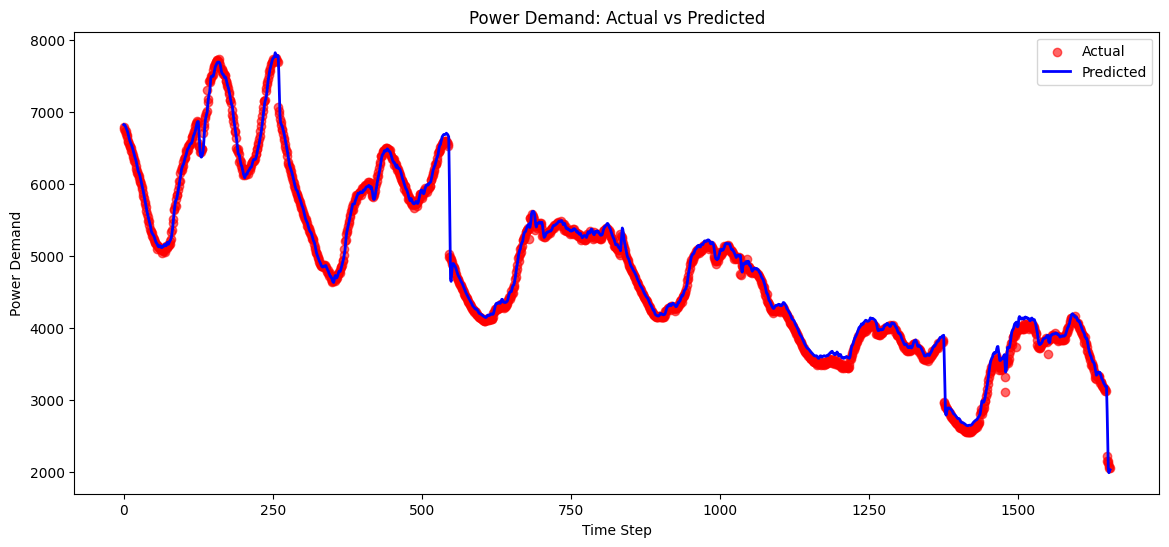

In [88]:
import matplotlib.pyplot as plt

# Choose the model you want to visualize
model_to_plot = vanilla_lstm  # or any other trained model

# Predict on test set
y_pred = model_to_plot.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# --------------------------
# Single Visualization: Actual (Scatter) vs Predicted (Line)
# --------------------------
plt.figure(figsize=(14,6))

# Scatter plot for actual values
plt.scatter(range(len(y_test_inv)), y_test_inv, label='Actual', color='red', alpha=0.6)

# Line plot for predicted values
plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Predicted', color='blue', linewidth=2)

plt.title("Power Demand: Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("Power Demand")
plt.legend()
plt.show()


In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Number of future steps (7 days * 24 hours * 4 intervals per hour)
future_steps = 7 * 24 * 4

# Start with the last sequence from test data
last_sequence = X_test[-1]  # shape: (time_steps, features)

future_predictions = []

current_sequence = last_sequence.copy()

for _ in range(future_steps):
    # Predict next step
    pred = vanilla_lstm.predict(current_sequence[np.newaxis, :, :])
    future_predictions.append(pred[0,0])

    # Update sequence: drop first timestep and append predicted value
    next_features = current_sequence[1:].copy()
    # Replace the target feature (moving_avg_3 or your main features if needed) with predicted
    # If moving_avg_3 is used, you might update it as rolling average of last predictions
    # Here we just append predicted power demand as the last feature (adjust if needed)
    next_row = current_sequence[-1].copy()  # keep other features same
    next_features = np.vstack([next_features, next_row])
    current_sequence = next_features

# Inverse scale predictions
future_predictions = np.array(future_predictions).reshape(-1,1)
future_predictions_inv = scaler_y.inverse_transform(future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


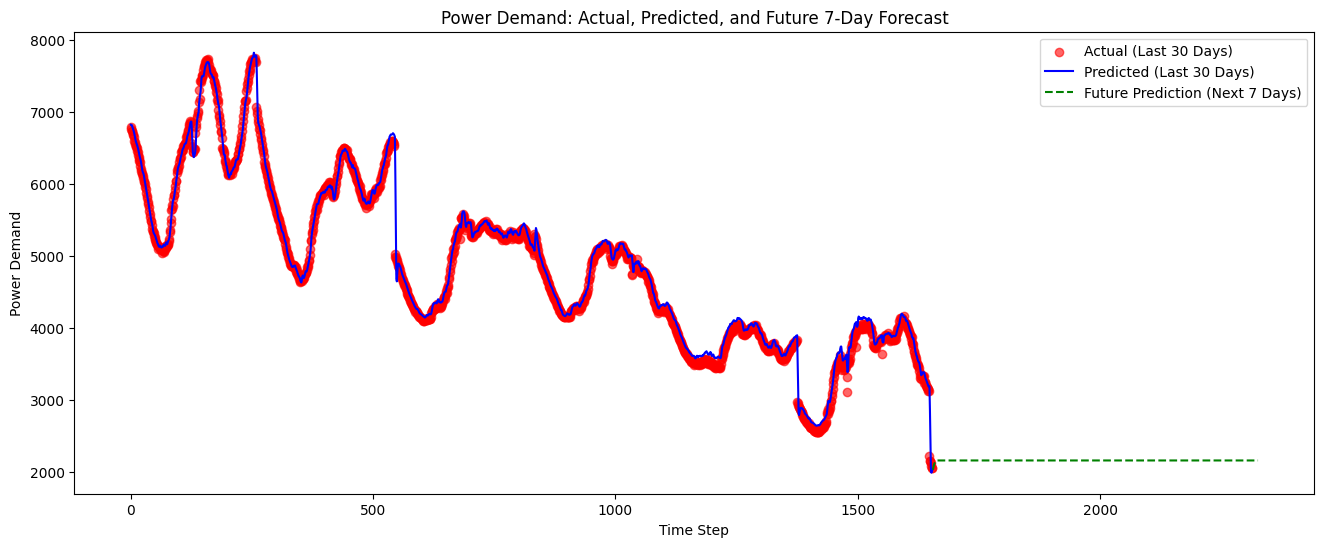

In [90]:
# Original last 100 points for plotting
y_test_inv = scaler_y.inverse_transform(y_test)

# Combine last actual + future predictions for visualization
combined = np.concatenate([y_test_inv, future_predictions_inv], axis=0)

plt.figure(figsize=(16,6))

# Plot last actual values as scatter
plt.scatter(range(len(y_test_inv)), y_test_inv, label='Actual (Last 30 Days)', color='red', alpha=0.6)

# Plot past predictions as line
plt.plot(range(len(y_test_inv)), scaler_y.inverse_transform(vanilla_lstm.predict(X_test)),
         label='Predicted (Last 30 Days)', color='blue')

# Plot future predictions as line
plt.plot(range(len(y_test_inv), len(combined)), future_predictions_inv,
         label='Future Prediction (Next 7 Days)', color='green', linestyle='--')

plt.title("Power Demand: Actual, Predicted, and Future 7-Day Forecast")
plt.xlabel("Time Step")
plt.ylabel("Power Demand")
plt.legend()
plt.show()
